# Simulation of a Prescribed Fire policy 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import rioxarray
from tqdm import tqdm
from prescribed.utils import prepare_template
from rasterio import transform
from prescribed.utils import expand_grid, grouper
from prescribed.plot import template_plots

from prescribed.estimate.simulations import (
    simulation_data, 
    sample_rx_years, 
    run_simulations
)

# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

In [3]:
policy_size = 1_000_000
size_rx = 1_000

print(f"Number of policy 1 sq-km pixels: {policy_size / 247.105}")
print(f"If all fires are of {size_rx} acres, then the size is: {size_rx / 247.105} sq-km")
print(f"Number of fires in the policy area: {policy_size / size_rx}")

Number of policy 1 sq-km pixels: 4046.8626697153036
If all fires are of 1000 acres, then the size is: 4.046862669715304 sq-km
Number of fires in the policy area: 1000.0


In [4]:
sim_data = simulation_data(
    template="/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif", 
    land_type="/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather", 
    roads=["/mnt/sherlock/oak/prescribed_data/raw/os_roads_ca/norcal/gis_osm_roads_free_1.shp",
           "/mnt/sherlock/oak/prescribed_data/raw/os_roads_ca/socal/gis_osm_roads_free_1.shp"
           ],
    only_roads = False,
    buf=10_000,
    road_type="secondary",
)

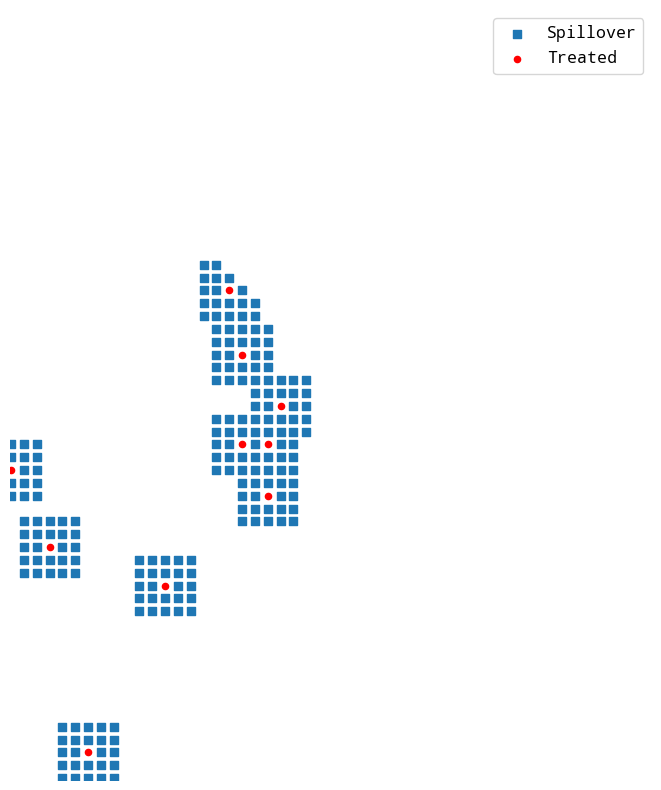

In [27]:
# Sim data as a geodataframe
sim_data = gpd.GeoDataFrame(sim_data, 
                            geometry=gpd.points_from_xy(
                                sim_data.lon, sim_data.lat))
sim_data = sim_data.set_crs(epsg=3310)

# Get a sample of the points
sim_data_sample = sim_data[(sim_data["land_type"] == 2) &
                           (sim_data.lon > 50000) & (sim_data.lon < 100000) &
                           (sim_data.lat > 10000) & (sim_data.lat < 70000)].sample(10)

# Transform to geopandas and then buffer the points
sim_data_gpd = gpd.GeoDataFrame(sim_data_sample, 
                            geometry=gpd.points_from_xy(
                                sim_data_sample.lon, sim_data_sample.lat))
sim_data_gpd = sim_data_gpd.set_crs(epsg=3310)


# Buffer the points to 5 km
sim_data_gpd["geometry"] = sim_data_gpd.buffer(2000, cap_style="square")


# Filter points that overlap with the buffered points
sample_complete = sim_data.overlay(sim_data_gpd.drop(columns=["lat", "lon", "grid_id"], errors="ignore"), how="intersection")

sample_complete = sample_complete.drop_duplicates(subset=["grid_id"])

sample_complete = sample_complete[~sample_complete.grid_id.isin(sim_data_sample.grid_id)]

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

sample_complete.plot(ax=ax, marker="s")

# Plot sampled points
sim_data_sample.plot.scatter(x='lon', y='lat', ax=ax, color="red")

# Plot the buffered points
#sim_data_gpd.plot(ax=ax, color="red", alpha=0.5)

# Set limits of the plot
ax.set_xlim(50000, 100000)
ax.set_ylim(10000, 70000)

# Apply template
template_plots(ax , no_axis=True, xlab="", ylab="")

# Add a legend to the plot to have red squares with transparency for buffers, red squared for treated and blue squares for untreated
ax.legend(["Spillover", "Treated"], loc="upper right")


# Save the plot
plt.savefig("../figs/spillovers_test.png", dpi=300, bbox_inches="tight")

In [27]:
# Prepare results
results = pd.read_csv("../data/results/att_conifers_dnbr.csv")
results["land_type"] = results.land_type.replace({"conifers": 2.0, "shrublands": 12.0})

spillover_results = pd.read_csv("../data/results/att_spillover.csv")
spillover_results = (spillover_results[spillover_results.dist_treat == 2000]
                     .drop(columns='dist_treat', errors="ignore")
                     .sort_values("year")
)

spillover_results = spillover_results[spillover_results.year <= 7]

sim_data = sim_data[sim_data.land_type.isin([2])]

# Prepare fire data
fire_data = (
    pd.read_feather("/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather")
    .drop(columns=["spatial_ref"], errors="ignore")
)
fire_data = fire_data[fire_data.year >= 2010]

# Prepare template
template = prepare_template("/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif", 
                            years=[2000, 2022])
template = template[template.year >= 2010]

In [86]:
test_sample = sample_rx_years(
    template = template, 
    treat_data = sim_data,
    fire_data = fire_data,
    estimates = results,
    size_treatment = 1_000,
    spillovers=True,
    spillover_size=2_000,
    spillover_estimates=spillover_results,
    start_year=2020,
    sample_n=1000,
)

Sampling years:  33%|███▎      | 1/3 [00:00<00:00,  7.92it/s]

0
20534


40867


In [108]:
run_simulations(
    template = template,
    sim_data = sim_data,
    results = results,
    fire_data = fire_data,
    save_path= "../data/sims_number_no_spill/",
    num_sims = 100,
    step_save = 10,
    size_treatment=1_000,
    start_year=2010,
    sample_n=10,
    crs="EPSG:3310",
    format="parquet",
    spillovers=False,
    spillover_size=2_000,
    spillover_estimates=spillover_results
)

Grouping simulations:   0%|          | 0/10 [00:00<?, ?it/s]

Grouping simulations: 100%|██████████| 10/10 [03:09<00:00, 18.97s/it]


### Plot animation of treatment 

In [38]:
test_sim = duckdb.query(
"""
select year_treat, count(distinct grid_id) as num_treated
from '../data/policy_spill_100/*.parquet'
where sim == 1
group by year_treat
"""
).to_df()

In [39]:
test_sim

,year_treat,num_treated
0,2010,2137
1,2014,2075
2,2015,2066
3,2018,1960
4,2012,2095
5,2020,2096
6,2011,1952
7,2016,2149
8,2021,2077
9,2013,2163


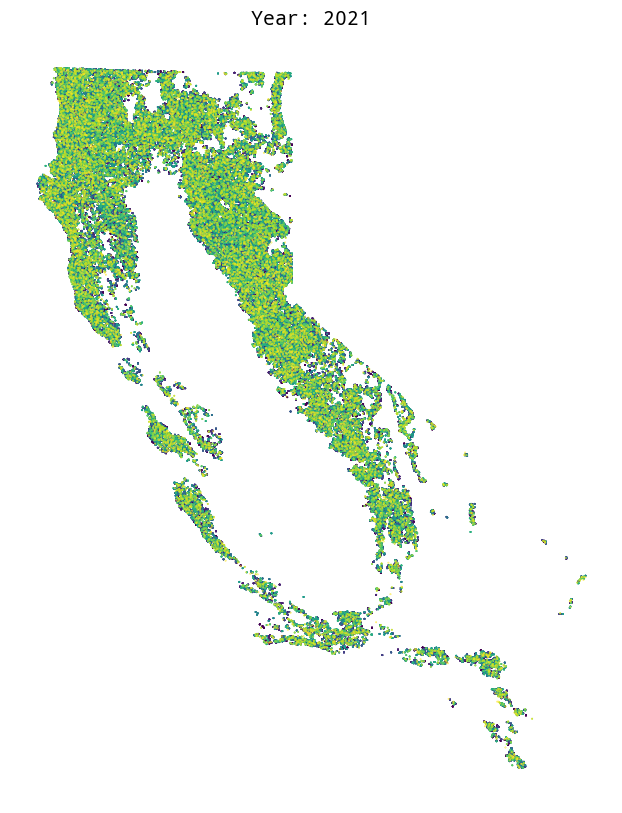

In [111]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.animation import FuncAnimation

# Assuming test_sim is already defined and is a GeoDataFrame
# test_sim = gpd.GeoDataFrame(...)  # Your GeoDataFrame initialization

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Set limits of the plot
#ax.set_xlim(-400_000, -300_000)
#ax.set_ylim(200_000, 400_000)

# Remove axis
ax.axis('off')

# Get unique years
years = sorted(test_sim['year_treat'].dropna().unique())

# Define the update function
def update(year):
    ax.clear()
    #ax.set_xlim(-400_000, -300_000)
    #ax.set_ylim(200_000, 400_000)
    ax.axis('off')
    test_sim[test_sim['year_treat'] <= year].plot(ax=ax, column='year_treat', legend=False, s=0.1)
    ax.set_title(f'Year: {year}')

# Create the animation
ani = FuncAnimation(fig, update, frames=years, repeat=False)

# Save the animation as a GIF or MP4
ani.save('animation.gif', writer='imagemagick', fps=1)
# ani.save('animation.mp4', writer='ffmpeg', fps=1)

# Display the animation
plt.show()

### Read simulations

In [36]:
import os
import seaborn as sns

# Load DNBR data and save to parquet to make it nicer for DuckDB
data_path = "/mnt/sherlock/oak/prescribed_data/"

template = prepare_template(
    os.path.join(data_path, "geoms/templates/template.tif")
)

dnbr = pd.read_feather(
    os.path.join(data_path, "processed/dnbr_gee_inmediate/dnbr_long.feather")
)

mtbs = gpd.read_file(
    os.path.join(data_path, "geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp")
).to_crs("EPSG:3310")

# Merge it to get years
mtbs["year"] = mtbs.Ig_Date.dt.year
dnbr = dnbr.merge(mtbs[["Event_ID", "year"]], right_on="Event_ID", left_on="event_id", how="left")
dnbr.drop(columns=["Event_ID"], inplace=True)

# Subset and save to parquet
#dnbr = dnbr[dnbr.year > 2010]
#dnbr["dnbr"] = np.where(dnbr.dnbr < 0, 0, dnbr.dnbr)
dnbr["low_severity"] = np.where((dnbr.dnbr <= 270) & (dnbr.dnbr > 100), 1, 0)
dnbr["high_severity"] = np.where((dnbr.dnbr > 660), 1, 0)

dnbr.to_parquet("../data/dnbr.parquet")

In [37]:
# Read in all the sims to merge with dnbr data
df = duckdb.query("""
with sim as (
SELECT lat, lon, year, year_treat, coeff, sim, land_type, grid_id
FROM '../data/policy_no_spill_4000/*.parquet') 
SELECT d.grid_id,
       d.event_id,
       d.year, 
       s.year_treat, 
       s.coeff, 
       s.sim, 
       d.dnbr,
       s.land_type,
       d.dnbr + s.coeff as sim_dnbr,
       d.low_severity,
       d.high_severity
FROM sim s
right join (SELECT grid_id, year, dnbr, low_severity, high_severity, event_id
                  FROM "../data/dnbr.parquet") as d
ON s.grid_id = d.grid_id AND s.year = d.year
""")

# Aggregated data by year and year_treat to plot
df_year_treat = duckdb.query("""
select year, year_treat, mean(coeff) as coeff_mean
from df
where year_treat is not null
group by year, year_treat
""")

# Aggregated data by year and sim to plot
df_year_treat_sim = duckdb.query("""
select year, year_treat, sim, mean(coeff) as coeff_mean
from df
group by year, sim, year_treat
""")


In [39]:
duckdb.query("""
select * from df where year_treat is null
""")

┌─────────┬───────────────────────┬───────┬────────────┬────────┬───────┬───────────┬───────────┬──────────┬──────────────┬───────────────┐
│ grid_id │       event_id        │ year  │ year_treat │ coeff  │  sim  │   dnbr    │ land_type │ sim_dnbr │ low_severity │ high_severity │
│  int64  │        varchar        │ int32 │   int64    │ double │ int64 │   float   │  double   │  double  │    int64     │     int64     │
├─────────┼───────────────────────┼───────┼────────────┼────────┼───────┼───────────┼───────────┼──────────┼──────────────┼───────────────┤
│  684667 │ CA3531811949919970519 │  1997 │       NULL │   NULL │  NULL │ 108.49943 │      NULL │     NULL │            1 │             0 │
│  318028 │ CA3893112229619980829 │  1998 │       NULL │   NULL │  NULL │   589.879 │      NULL │     NULL │            0 │             0 │
│  318944 │ CA3880312232819991016 │  1999 │       NULL │   NULL │  NULL │       0.0 │      NULL │     NULL │            0 │             0 │
│  319861 │ CA389161

<Axes: xlabel='Year', ylabel='Simulated change in $\\Delta$NBR'>

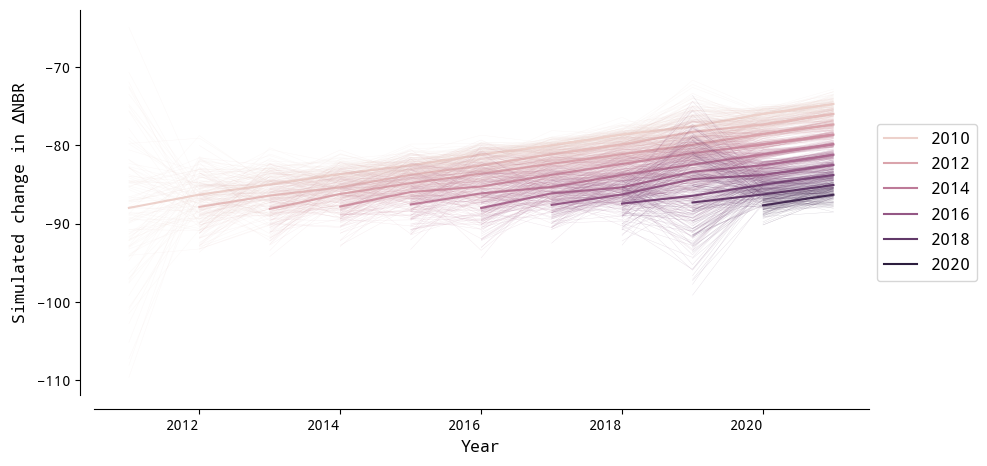

In [19]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(
    data = df_year_treat.to_df(),
    x="year", 
    y="coeff_mean", 
    hue="year_treat",
    ax=ax
)

sns.lineplot(
    data = df_year_treat_sim.to_df(),
    x="year", 
    y="coeff_mean", 
    units='sim',
    estimator=None,
    hue="year_treat",
    legend=False,
    linewidth=0.25,
    ax=ax,
    alpha=0.2
)

# Move legend to the right outside of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Apply template
template_plots(ax, xlab="Year", ylab=r"Simulated change in $\Delta$NBR")

# Save plot
#plt.savefig("../figs/simulations_coefs.png", bbox_inches="tight")

/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/joypy/joyplot.py:234: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")


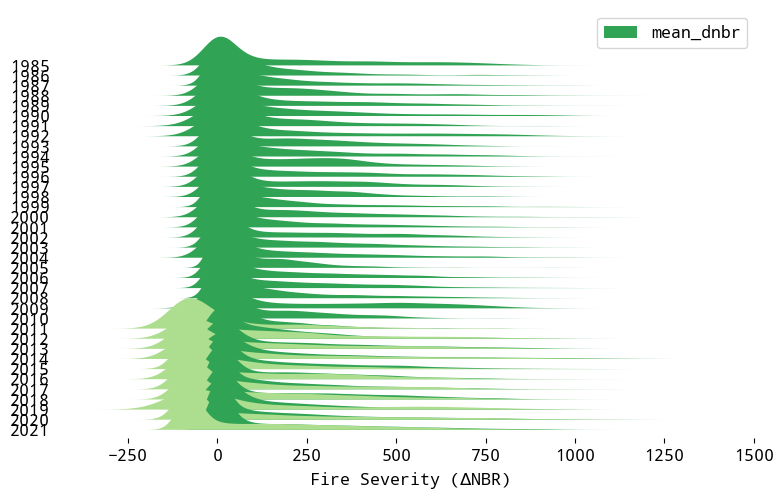

In [190]:
import joypy

dist_state = duckdb.query("""
select year, grid_id, 
    mean(dnbr) as mean_dnbr, 
    mean(sim_dnbr) as mean_sim_dnbr
from df 
where year is not NULL
group by year, grid_id
""").to_df()

#dist_state = pd.read_csv("../data/joyplot_data.csv")

labels = [str(int(d)) for d in dist_state.year.unique()]
fig, axes = joypy.joyplot(dist_state,
                        by="year", 
                        column=["mean_dnbr", "mean_sim_dnbr"],
                        legend=True,
                        figsize=(8,5),
                        fade=False,
                        overlap=1,
                        linewidth=0,
                        tails=0.1,
                        fill=True,
                        ylim = 'max', 
                        #sublabels = ["$\Delta$NBR", "Simulated $\Delta$NBR"],
                        color=["#31a354", "#addd8e"],
                        )

# Change axis labels
for ax in axes:
    ax.set_xlabel("Fire Severity ($\Delta$NBR)")
# Save plot
#plt.savefig("../figs/dnbr_simulated_joy.png", dpi=300, bbox_inches="tight")

### Check totals across state to calculate benefits

#### Severity 

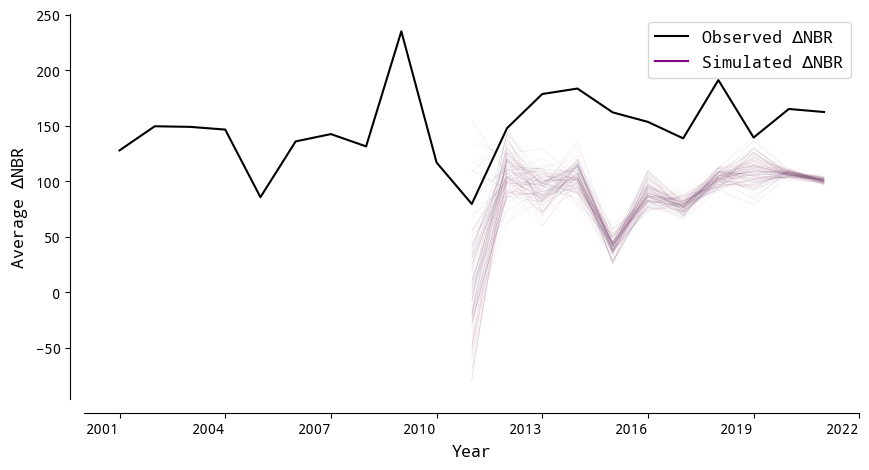

In [ ]:
import matplotlib.lines as mlines
import seaborn as sns

severity_raw = duckdb.query("""
select year, 
    sum(dnbr) as sum_dnbr,
    mean(dnbr) as mean_dnbr
from '../data/dnbr.parquet'
where year > 2000
group by year
""").to_df()

severity = duckdb.query("""
with sim as (
SELECT lat, lon, year, year_treat, coeff, sim, land_type, grid_id
FROM '../data/policy_no_spill_4000/*.parquet'),
df as (
SELECT d.grid_id,
       d.year, 
       d.event_id,
       s.year_treat, 
       s.sim, 
       d.dnbr, 
       d.dnbr - abs(s.coeff) as sim_dnbr
FROM sim s
right join (SELECT grid_id, year, dnbr, event_id
            FROM "../data/dnbr.parquet") as d
ON s.grid_id = d.grid_id AND s.year = d.year),
df_sim as (
select year, 
    sim,
    mean(sim_dnbr) as sum_sim_dnbr,
from df
group by sim, year
) 
select *
from df_sim
where year > 2010
""").to_df()

# Use seaborn to plot the time series data and hue by simulation
fig, ax = plt.subplots(1, 1, figsize=(10, 5))


severity_raw.plot.line(x="year", 
                       y="mean_dnbr", 
                       ax=ax, 
                       label="Observed $\Delta$NBR",
                       color="black")

sns.lineplot(
    data = severity,
    x="year", 
    hue="sim",
    y="sum_sim_dnbr", 
    linewidth=0.25,
    ax=ax,
    alpha=0.2,
    legend=False
)

# Apply template
template_plots(ax, xlab="Year", ylab=r"Average $\Delta$NBR")

# Change x-axis labels to be integers
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add only one label for the simulated lines
# Add custom legend entries
observed_line = mlines.Line2D([], [], color='black', label='Observed $\Delta$NBR')
simulated_line = mlines.Line2D([], [], color='purple', label='Simulated $\Delta$NBR')
ax.legend(handles=[observed_line, simulated_line], loc='upper right')


# Save plot
plt.savefig("../figs/simulated_severity.png", bbox_inches="tight")


#### Emissions

In [8]:
duckdb.query("""
select *
from '/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/county_smoke_pm.parquet'
""")

┌────────┬────────────────────┬────────────────────┬────────────┐
│  year  │      mean_pm       │       sum_pm       │ total_days │
│ double │       double       │       double       │   int32    │
├────────┼────────────────────┼────────────────────┼────────────┤
│ 2006.0 │ 1.8529830231501594 │  6822.683491238888 │       3682 │
│ 2007.0 │ 2.1463079655843096 │  6904.672725284724 │       3217 │
│ 2008.0 │  7.660725761654313 │ 40027.292104643784 │       5225 │
│ 2009.0 │ 1.7962574528881592 │  5349.254694700938 │       2978 │
│ 2010.0 │ 0.8585841318078181 │ 1946.4102268083236 │       2267 │
│ 2011.0 │ 0.8884292133493936 │ 2468.0563546846156 │       2778 │
│ 2012.0 │  2.925207749137347 │  9021.340698339578 │       3084 │
│ 2013.0 │   3.09704130108263 │ 13438.062205397531 │       4339 │
│ 2014.0 │  2.858354142493882 │  9166.741734977879 │       3207 │
│ 2015.0 │  3.934773778436078 │ 14574.402075327233 │       3704 │
│ 2016.0 │ 2.1232250140649302 │  8034.283453221696 │       3784 │
│ 2017.0 │

In [ ]:
def make_predictions(severity, coefficients, degree):
    """ Create predictions using regression coefficients 

    Use simulated severity array to create predictions for each year passed
    in the coefficients array.

    Parameters
    ----------
    severity : np.array
        Array of simulated severity values
    coefficients : np.array
        Array of coefficients to use for the prediction
    
    Returns
    -------
    predictions : np.array
        Array of predictions for each year
    """ 

    # Check degree agrees with the number of coefficients
    assert len(coefficients) != degree + 1, "Non-comformal!"





In [75]:
duckdb.query("""
select d.*, s.sim
from (
select * from '../data/dnbr.parquet'
where year >= 2010) as d
cross join (
    select range as sim
    from range(100)
) as s
""")

┌─────────────────────┬─────────────────────┬───────────┬───────────────────────┬─────────┬───────┬──────────────┬───────────────┬───────┐
│         lat         │         lon         │   dnbr    │       event_id        │ grid_id │ year  │ low_severity │ high_severity │  sim  │
│       double        │       double        │   float   │        varchar        │  int64  │ int32 │    int64     │     int64     │ int64 │
├─────────────────────┼─────────────────────┼───────────┼───────────────────────┼─────────┼───────┼──────────────┼───────────────┼───────┤
│  103152.59699662775 │ -199913.82085035858 │ 264.79144 │ CA3850412233720200817 │  318026 │  2020 │            1 │             0 │     0 │
│  103152.59699662775 │ -198913.82085035858 │ 192.00705 │ CA3850412233720200817 │  318027 │  2020 │            1 │             0 │     0 │
│  103152.59699662775 │ -197913.82085035858 │ 265.01398 │ CA3850412233720200817 │  318028 │  2020 │            1 │             0 │     0 │
│  103152.59699662775 │ -19

In [202]:
df = duckdb.query(f"""
WITH cross_product AS (
    SELECT d.*, s.sim
    FROM (
        SELECT * FROM '../data/dnbr.parquet'
        WHERE year >= 2010
    ) AS d
    CROSS JOIN (
        SELECT range AS sim
        FROM range(100)
    ) AS s
),
sim AS (
    SELECT lat, lon, year, year_treat, coeff, sim, land_type, grid_id
    FROM '../data/policy_no_spill_4000/*.parquet'
)
SELECT d.grid_id,
    d.year, 
    d.event_id,
    s.year_treat, 
    s.coeff, 
    d.sim, 
    d.dnbr, 
    s.land_type,
    d.dnbr + coalesce(s.coeff, 0) as sim_dnbr
FROM sim s
RIGHT JOIN cross_product AS d
ON s.grid_id = d.grid_id AND s.year = d.year AND s.sim = d.sim
""")

sim_severity = duckdb.query(f"""
with year_agg as (
select event_id,
        year,                            
        sim, 
        sum(sim_dnbr) as sum_sim_dnbr,
from df
group by sim, event_id, year
)
select * from year_agg
""").to_df()

sim_severity


,event_id,year,sim,sum_sim_dnbr
0,CA3812011994120170904,2017,17,-227.668657
1,CA4083912297820170808,2017,17,1155.753747
2,CA3982012144020181108,2018,17,146431.838170
3,CA3612312160220200819,2020,17,219498.047097
4,CA4106412076220200720,2020,17,19602.152098
...,...,...,...,...
51895,CA3595912083320210530,2021,59,1540.176561
51896,CA3341811755020140516,2014,62,758.244299
51897,CA3510511831220120717,2012,36,752.411744
51898,CA3257311670020190814,2019,37,125.557746


In [182]:
import pyfixest as pf

smoke_linked = pd.read_feather("/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather")

fit = pf.feols(
    fml="sum_contrib ~ sum_severity + I(sum_severity ** 2) + total_days + total_pixels", 
    data=smoke_linked[smoke_linked.coverage_threshold == 0.6]
)
fit.summary()

###

Estimation:  OLS
Dep. var.: sum_contrib, Fixed effects: 
Inference:  iid
Observations:  494

| Coefficient          |   Estimate |   Std. Error |   t value |   Pr(>|t|) |       2.5% |      97.5% |
|:---------------------|-----------:|-------------:|----------:|-----------:|-----------:|-----------:|
| Intercept            | -50796.376 |     6100.438 |    -8.327 |      0.000 | -62782.683 | -38810.070 |
| sum_severity         |      1.202 |        0.156 |     7.719 |      0.000 |      0.896 |      1.508 |
| I(sum_severity ** 2) |      0.000 |        0.000 |    12.964 |      0.000 |      0.000 |      0.000 |
| total_days           |   6833.480 |      469.017 |    14.570 |      0.000 |   5911.942 |   7755.019 |
| total_pixels         |    -38.285 |       20.635 |    -1.855 |      0.064 |    -78.829 |      2.259 |
---
RMSE: 87250.127 R2: 0.875 


In [194]:
import statsmodels.formula.api as smf

fit = smf.ols(
    "sum_contrib ~ sum_severity + I(sum_severity**2) + total_days + total_pixels",
    data=smoke_linked[smoke_linked.coverage_threshold == 0.6]).fit()
fit.summary()


print(fit.summary())


                            OLS Regression Results                            
Dep. Variable:            sum_contrib   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     857.0
Date:                Fri, 08 Nov 2024   Prob (F-statistic):          2.45e-219
Time:                        20:24:09   Log-Likelihood:                -6321.0
No. Observations:                 494   AIC:                         1.265e+04
Df Residuals:                     489   BIC:                         1.267e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -5.08e+04 

In [225]:
smoke_linked[smoke_linked.coverage_threshold == 0.6].groupby("year").sum_contrib.sum()

year
2006.0    6.137434e+05
2007.0    8.402330e+05
2008.0    3.054373e+06
2009.0    7.755286e+05
2010.0    1.589446e+04
2011.0    6.044961e+04
2012.0    2.095739e+06
2013.0    2.002026e+06
2014.0    1.114579e+06
2015.0    2.187858e+06
2016.0    9.500165e+05
2017.0    2.737907e+06
2018.0    5.690054e+06
2019.0    1.491765e+05
2020.0    1.211583e+07
Name: sum_contrib, dtype: float64

In [222]:
# sim_severity = sim_severity.merge(
#     smoke_linked[smoke_linked.coverage_threshold==0.6], 
# on="event_id")

poly = sim_severity[sim_severity.sim == 90][["sum_sim_dnbr"]].values[..., None]
controls = sim_severity[sim_severity.sim == 90][["total_days", "total_pixels"]].values[..., None]
X = np.hstack([np.ones(poly.shape), poly, np.power(poly, 2), controls]).squeeze()

coefs = np.array([ -5.08e+04,1.2022 ,  1.025e-06, 6833.4804, -38.2850])
(coefs @ X.T).sum()

23507863.290789954

In [217]:
X

array([[1.00000000e+00, 1.44610482e+05, 2.09121916e+10, 1.80000000e+01,
        1.22500000e+03],
       [1.00000000e+00, 2.21418469e+05, 4.90261384e+10, 4.20000000e+01,
        9.18000000e+02],
       [1.00000000e+00, 1.97469899e+04, 3.89943608e+08, 1.30000000e+01,
        2.52000000e+02],
       ...,
       [1.00000000e+00, 1.19290287e+03, 1.42301725e+06, 5.00000000e+00,
        8.00000000e+00],
       [1.00000000e+00, 2.24403828e+02, 5.03570782e+04, 5.00000000e+00,
        2.50000000e+01],
       [1.00000000e+00, 1.57182901e+03, 2.47064645e+06, 4.00000000e+00,
        1.20000000e+01]])

In [208]:
23_795_916

23795916

In [ ]:
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather", 
)
dnbr = dnbr.merge(land_type[["grid_id", "land_type"]], on="grid_id", how="left")
dnbr

,lat,lon,dnbr,event_id,grid_id,year,low_severity,high_severity,land_type
0,-312847.403003,-38913.82085,197.871948,CA3518512041619860826,699243,1986,1,0,12.0
1,-312847.403003,-38913.82085,0.000000,CA3534412027619960815,699243,1996,0,0,12.0
2,-312847.403003,-38913.82085,34.139801,CA3528712050619850701,699243,1985,0,0,12.0
3,-312847.403003,-37913.82085,56.233170,CA3518512041619860826,699244,1986,0,0,12.0
4,-312847.403003,-37913.82085,0.000000,CA3534412027619960815,699244,1996,0,0,12.0
...,...,...,...,...,...,...,...,...,...
211909,121152.596997,-40913.82085,268.046356,CA3909912049020010825,301697,2001,1,0,2.0
211910,121152.596997,-39913.82085,136.908600,CA3909912049020010825,301698,2001,1,0,2.0
211911,121152.596997,-38913.82085,25.946465,CA3909912049020010825,301699,2001,0,0,2.0
211912,121152.596997,-37913.82085,0.000000,CA3909912049020010825,301700,2001,0,0,2.0


In [ ]:
def calculate_benefits(n_treats, discount_rate, **kwargs):

    # Load the data at the simulation level and combine with observed data
    df = duckdb.query(f"""
    with sim as (
    SELECT lat, lon, year, year_treat, coeff, sim, land_type, grid_id
    FROM '../data/policy_spill_{n_treats}/*.parquet') 
    SELECT d.grid_id,
        d.year, 
        d.event_id,
        s.year_treat, 
        s.coeff, 
        s.sim, 
        d.dnbr, 
        s.land_type,
        d.dnbr + s.coeff as sim_dnbr
    FROM sim s
    right join (SELECT grid_id, year, dnbr, event_id
                    FROM "../data/dnbr.parquet") as d
    ON s.grid_id = d.grid_id AND s.year = d.year
    """)

    # Now calculate the benefits and costs. We need to transform the severity
    # sums into emissions using the predictions of the models we estimated using
    # the matched emissions coming from Wen et al. (2023). 
    benefits = duckdb.query(f"""
    with year_agg as (
    select event_id,
           year,                            
           sim, 
           (sum(dnbr) - sum(sim_dnbr)) as b
    from df
    where year > 2010
    group by sim, event_id, year
    )
    select year,
        median(benefit) as mean_benefit,
        percentile_cont(0.25) within group (order by benefit) as benefit_q25,
        percentile_cont(0.75) within group (order by benefit) as benefit_q75,
        median(cost) as mean_cost,
        median(benefit) - mean(cost) as net_benefit
    from year_agg
    where year is not NULL
    group by year
    """).to_df()

    # Calculate the net present value
    benefits = benefits.assign(
        net_benefit_q25 = benefits.benefit_q25 - benefits.mean_cost,
        net_benefit_q75 = benefits.benefit_q75 - benefits.mean_cost,
        n_treats = n_treats
    )
    
    total_years = benefits.shape[0]
    # Stream of discounts
    if isinstance(discount_rate, float):
        discount_rate = np.repeat(discount_rate, benefits.shape[0])
        total_years = benefits.shape[0]
        discount_stream = 1 / (1 + discount_rate) ** np.arange(1, total_years + 1)

        # Calculate the net present value
        out = pd.DataFrame({
            "npv_mean": (benefits.net_benefit * discount_stream).sum(),
            "npv_q25": (benefits.net_benefit_q25 * discount_stream).sum(),
            "npv_q75": (benefits.net_benefit_q75 * discount_stream).sum(),
            "n_treats": n_treats,
            "discount_rate": discount_rate,
            "alpha": alpha
        }, index=[0]) 
    elif isinstance(discount_rate, list):
        out = []
        for dr in discount_rate:
            discount_stream = 1 / ((1 + dr) ** np.arange(1, total_years + 1))

            # Calculate the net present value
            out.append(pd.DataFrame({
                "npv_mean": (benefits.net_benefit * discount_stream).sum(),
                "npv_q25": (benefits.net_benefit_q25 * discount_stream).sum(),
                "npv_q75": (benefits.net_benefit_q75 * discount_stream).sum(),
                "n_treats": n_treats,
                "discount_rate": dr,
                "alpha": alpha
            }, index=[0]))
        out = pd.concat(out)
    else:
        raise ValueError("Discount rate must be a float or a list of floats")
        
    return out, benefits


In [32]:
total_benefits = []
total_npv = []

#for i in range(500, 4500, 500):
for i in [50, 100, 150]:
    dr = [i for i in np.arange(0.01, 0.11, 0.01)]
    npv, benefits = calculate_benefits(i, dr)
    total_benefits.append(benefits)
    total_npv.append(npv)

total_benefits = pd.concat(total_benefits)
total_npv = pd.concat(total_npv)


In [33]:
total_benefits.sort_values("year")

,year,mean_benefit,benefit_q25,benefit_q75,mean_cost,net_benefit,net_benefit_q25,net_benefit_q75,n_treats
0,2011,6.498912,3.180144,11.611959,75.0,-68.501088,-71.819856,-63.388041,50
0,2011,11.423925,4.685784,19.593592,225.0,-213.576075,-220.314216,-205.406408,150
0,2011,11.575390,4.747890,20.197839,150.0,-138.424610,-145.252110,-129.802161,100
1,2012,34.615961,17.903798,52.157436,75.0,-40.384039,-57.096202,-22.842564,50
1,2012,102.016964,77.165720,133.125711,225.0,-122.983036,-147.834280,-91.874289,150
1,2012,66.969602,41.026425,86.131616,150.0,-83.030398,-108.973575,-63.868384,100
2,2013,57.417299,39.859394,86.112741,75.0,-17.582701,-35.140606,11.112741,50
2,2013,169.353803,141.338083,199.874613,225.0,-55.646197,-83.661917,-25.125387,150
2,2013,105.473541,81.184690,144.419482,150.0,-44.526459,-68.815310,-5.580518,100
3,2014,110.923485,88.588151,141.077235,75.0,35.923485,13.588151,66.077235,50


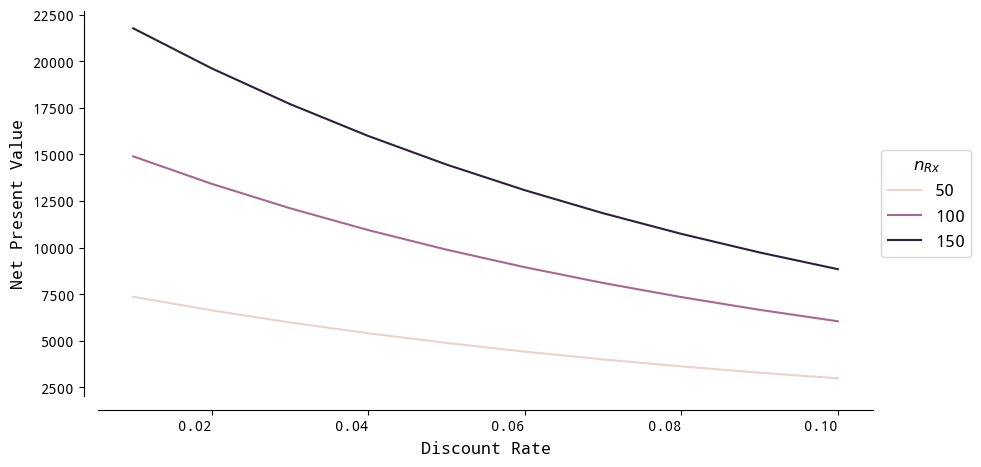

In [40]:
total_npv.sort_values("discount_rate")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=total_npv, x="discount_rate", y="npv_mean", hue="n_treats")

template_plots(ax, xlab="Discount Rate", ylab="Net Present Value")

# Move the legend outside the plot and change the title
plt.legend(title=r"$n_{Rx}$", loc='center left', bbox_to_anchor=(1, 0.5))

# Save plot
plt.savefig("../figs/npv_spill.png", bbox_inches="tight")

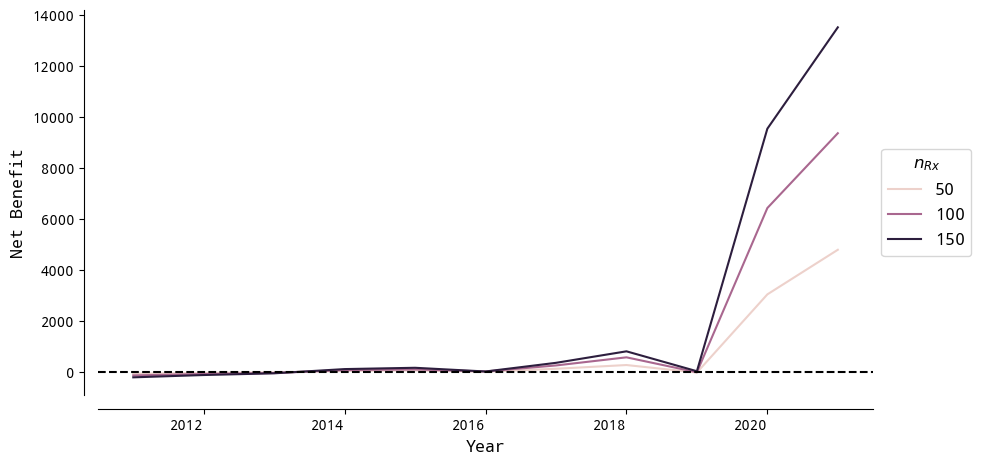

In [41]:
total_benefits

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(
    x='year',
    y='net_benefit',
    ax=ax,
    #data=total_benefits[total_benefits.n_treats == 500],
    data=total_benefits,
    hue='n_treats'
)

template_plots(ax, xlab="Year", ylab="Net Benefit")

# Add a horizontal line at 0
ax.axhline(0, color='black', linestyle='--')

# Move the legend outside the plot and change the title
plt.legend(title=r"$n_{Rx}$", loc='center left', bbox_to_anchor=(1, 0.5))

# Save plot
plt.savefig("../figs/benefit_spill.png", bbox_inches="tight")

In [21]:
duckdb.query("""
-- select year, sum(mean_dnbr) - sum(mean_sim_dnbr) as mean_diff
select year, sum(mean_sim_dnbr) as mean_diff
from dist_state
group by year
order by 1
""")

┌───────┬─────────────────────┐
│ year  │      mean_diff      │
│ int32 │       double        │
├───────┼─────────────────────┤
│  2011 │ -1031.5402104710315 │
│  2012 │   184173.2398159698 │
│  2013 │  173735.78491529438 │
│  2014 │  302332.83654550224 │
│  2015 │   94733.70626704299 │
│  2016 │   153097.3706128937 │
│  2017 │  259905.03463048843 │
│  2018 │  338350.66074071947 │
│  2019 │   58448.07879200987 │
│  2020 │  1357136.7622676601 │
│  2021 │  1435508.9643291254 │
├───────┴─────────────────────┤
│ 11 rows           2 columns │
└─────────────────────────────┘

In [17]:
axes[-1].plot([0, 0], [0, 0], color="#31a354", label="Observed $\Delta$NBR")

In [55]:
duckdb.query("""
select year, count(*) as n, sum(high_severity) as high_severity
from dnbr
group by year 
order by 1
""")

┌───────┬───────┬───────────────┐
│ year  │   n   │ high_severity │
│ int32 │ int64 │    int128     │
├───────┼───────┼───────────────┤
│  2011 │  2211 │             7 │
│  2012 │  4986 │           173 │
│  2013 │  4326 │           242 │
│  2014 │  4328 │           319 │
│  2015 │  6224 │           202 │
│  2016 │  4662 │           121 │
│  2017 │ 11884 │           304 │
│  2018 │ 12523 │           562 │
│  2019 │  2226 │            87 │
│  2020 │ 39587 │          2183 │
│  2021 │ 25849 │          1196 │
├───────┴───────┴───────────────┤
│ 11 rows             3 columns │
└───────────────────────────────┘

In [40]:
duckdb.query("""
select year, count(*) as n, sum(high_severity) as high_severity
from dnbr
group by year 
order by 1
""")

┌───────┬───────┬───────────────┐
│ year  │   n   │ high_severity │
│ int32 │ int64 │    int128     │
├───────┼───────┼───────────────┤
│  2011 │  2211 │             7 │
│  2012 │  4986 │           173 │
│  2013 │  4326 │           242 │
│  2014 │  4328 │           319 │
│  2015 │  6224 │           202 │
│  2016 │  4662 │           121 │
│  2017 │ 11884 │           304 │
│  2018 │ 12523 │           562 │
│  2019 │  2226 │            87 │
│  2020 │ 39587 │          2183 │
│  2021 │ 25849 │          1196 │
├───────┴───────┴───────────────┤
│ 11 rows             3 columns │
└───────────────────────────────┘

In [41]:
duckdb.query("""
with low as (
select 
             *, 
             case 
             when sim_dnbr > 660
             then 1 
             else 0 
             end as high_severity_sim
from df
),
a as (
select year, 
       grid_id,
       mean(high_severity_sim) as high_severity_sim
from low
group by year, grid_id
)
select year, sum(high_severity_sim) as n from a group by year 
order by 1
""")

┌───────┬────────────────────┐
│ year  │         n          │
│ int32 │       double       │
├───────┼────────────────────┤
│  2011 │                3.2 │
│  2012 │  82.88272005772002 │
│  2013 │  86.58851426351428 │
│  2014 │ 219.94311987032577 │
│  2015 │ 55.958349609253176 │
│  2016 │  40.37617953463529 │
│  2017 │ 113.11536795619806 │
│  2018 │ 134.78088419824516 │
│  2019 │  39.85030414688796 │
│  2020 │  1122.985345378247 │
│  2021 │  516.4917666681978 │
├───────┴────────────────────┤
│ 11 rows          2 columns │
└────────────────────────────┘

### Estimate $\alpha^{*}$

In [109]:
smoke_linked = pd.read_feather("/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather")
smoke_linked = smoke_linked[
    (smoke_linked.sum_severity <= smoke_linked.sum_severity.quantile(0.75)) & 
    (smoke_linked.sum_severity >= smoke_linked.sum_severity.quantile(0.25))
]

smoke_linked.describe()

,mean_severity,sum_severity,land_type_mode,pixels_low_severity,pixels_mod_low_severity,pixels_mod_high_severity,pixels_high_severity,share_low_severity,share_high_severity,total_pixels,rx_pixels,year,coverage_threshold,sum_contrib,mean_contrib,total_days,rx_fire,sum_contrib_km,sum_severity_km
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.0,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.0,2111.000000,2111.000000
mean,137.137271,8492.791128,6.591663,63.710090,7.755092,4.379915,1.546660,0.771078,0.030147,77.391757,0.0,2012.316911,0.474135,17991.970711,7197.703936,2.261014,0.0,276.673849,137.137271
std,61.207845,5694.904493,4.775134,61.148342,6.424198,4.873825,2.457521,0.134052,0.046531,66.239938,0.0,4.317109,0.247018,34389.413372,12062.709737,0.484441,0.0,414.636108,61.207845
min,22.782652,2359.961546,1.000000,3.000000,0.000000,0.000000,0.000000,0.333333,0.000000,9.000000,0.0,2006.000000,0.100000,0.000000,0.000000,1.000000,0.0,0.000000,22.782652
25%,93.004065,3901.969500,2.000000,20.000000,3.000000,1.000000,0.000000,0.684211,0.000000,30.000000,0.0,2008.000000,0.300000,1884.740266,928.755980,2.000000,0.0,33.900796,93.004065
50%,129.513028,6801.391213,3.000000,40.000000,6.000000,3.000000,0.000000,0.777778,0.000000,56.000000,0.0,2013.000000,0.500000,7341.844204,3345.233065,2.000000,0.0,127.682047,129.513028
75%,174.164348,11353.441477,12.000000,90.000000,11.000000,6.000000,2.000000,0.872804,0.048611,105.000000,0.0,2016.000000,0.700000,19277.930976,8251.058977,3.000000,0.0,329.452155,174.164348
max,390.693145,22488.052939,12.000000,346.000000,33.000000,24.000000,17.000000,1.000000,0.250000,357.000000,0.0,2020.000000,1.000000,348617.275145,116205.758382,3.000000,0.0,3275.158995,390.693145


In [110]:
from prescribed.plot import get_best_poly_fit, run_fit_curve
from matplotlib import cm

viridis = cm.get_cmap("viridis")
viridis_list = [viridis(i) for i in smoke_linked.coverage_threshold.unique()]

run_fit_curve(smoke_linked, 
              ax=ax,
              by="coverage_threshold",
              x_col="sum_severity",
              y_col="sum_contrib",
              plot=False,
              cmap=viridis_list)

/tmp/ipykernel_3667250/3195979275.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap("viridis")


,coverage_threshold,best_degree,pred
0,0.1,8,7228.287565
1,0.2,1,-4764.234796
2,0.3,1,-4351.672767
3,0.4,1,-5175.687101
4,0.5,8,8444.270925
5,0.6,1,-3724.042043
6,0.7,9,10935.500216
7,0.8,4,13579.766268
8,0.9,1,-12446.178614
9,1.0,6,2973.770953


/tmp/ipykernel_3667250/3303858406.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mod_data["sum_severity"],


<Axes: xlabel='Total Severity', ylabel='Total PM2.5 Contribution'>

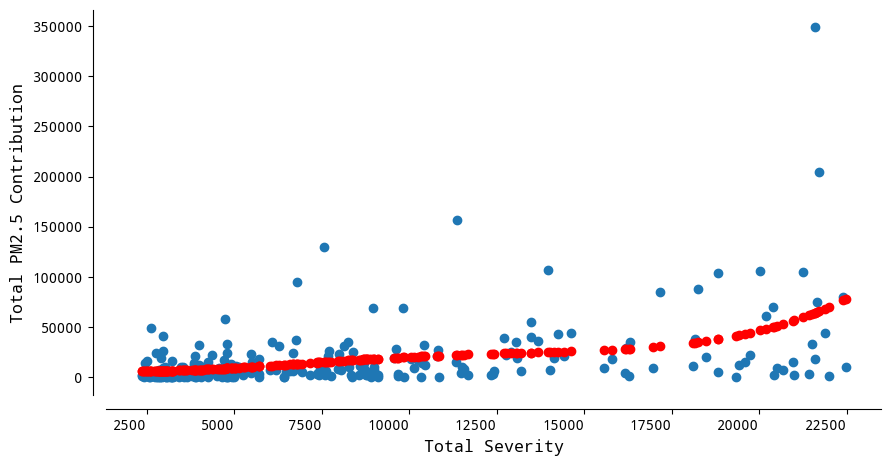

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

mod_data = smoke_linked[smoke_linked.coverage_threshold == 0.8]

# Get the best polynomial fit
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
X = mod_data.sum_severity.values.reshape(-1, 1)
y = mod_data.sum_contrib.values

poly = PolynomialFeatures(degree=4, include_bias=False).fit_transform(X)
model = LinearRegression().fit(poly, y)
y_pred = model.predict(poly)

plt.scatter(mod_data["sum_severity"], 
           mod_data["sum_contrib"],  
           cmap=viridis)
plt.scatter(X, y_pred, color="red")

# Apply template
template_plots(ax, xlab="Total Severity", ylab="Total PM2.5")

